In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import vr2p
from vr2p import styles
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel

# Get relevant data.

* Sessions are broken by timestamp in equal sized periods
* sessions without licks are not used (no information)
* keeps track of number of trials to see if there is low amount of data for proper values.

In [2]:
# Parameters
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
remove_licks_on_place = True # these can both be true.
remove_licks_on_time = False
remove_licks_after_reward_sec = 4 # in seconds.
remove_licks_after_reward_cm = 10 # in cm
time_range = [0,40] # time period to break into seperate periods
near_position = [120,150] #130,150
far_position = [170,200] #180,200

info = []
max_session = 0
for animal in tqdm(animals,desc='animals'):
    # load data.
    data = vr2p.ExperimentData(f'gs://linear-2ac/Set A/Tyche-{animal}-SetA.zarr')
    # got through sessions.
    animal_info = pd.DataFrame()
    for i_session, vr in tqdm(enumerate(data.vr)):
        session_info = {}
        trial = vr.trial.copy()
        lick = vr.lick.copy()
        # select needed info
        lick=lick[['time','position','trial_number']]
        # remove licks outside of trials.
        lick =lick[lick['trial_number'].isnull()==False]
        lick['trial_number'] = lick['trial_number'].astype('int')
        # remove licks.
        # remove based on proximity to reward
        reward = vr.reward.copy()
        if remove_licks_on_place:
            # Go through reward.
            filter_ind = [] # stores lick indices to remove
            for index, row in reward.iterrows():
                is_trial = (lick.trial_number==row.trial_number)
                is_in_pos = (lick.position.between(row.position,row.position+remove_licks_after_reward_cm))
                is_in_time = (lick.time.between(row.time,row.time+pd.to_timedelta(remove_licks_after_reward_sec,unit='s')))
                if remove_licks_on_time:
                    filter_ind.append(lick.loc[is_trial & is_in_pos & is_in_time].index.to_numpy())
                else:
                    filter_ind.append(lick.loc[is_trial & is_in_pos].index.to_numpy())    
            lick = lick.drop(np.hstack(filter_ind))
        # remove based on time
        else:
            for index, row in reward.iterrows():
                lick = lick.loc[lick.time.between(row.time,row.time + pd.to_timedelta(remove_licks_after_reward_sec, unit="s"))==False]
        #  select data.
        trial = trial[['trial_number','reward_id','is_guided','status']]

        # add lick position data.
        lick['near'] = lick.position.between(near_position[0],near_position[1])
        lick['far'] = lick.position.between(far_position[0],far_position[1])
        lick['outside'] = (lick['near']==False)&(lick['far']==False)
        # group.
        lick = lick[['near','far',"outside",'trial_number']].groupby(['trial_number']).sum().reset_index()  
        # get total licks.
        lick['total'] = lick['near']+lick['far']+ lick['outside']
        # get percentages.
        lick['near_perc'] = (lick['near']/lick['total'])*100
        lick['far_perc'] = (lick['far']/lick['total'])*100
        lick['outside_perc'] = (lick['outside']/lick['total'])*100
        # add information to lick dataframe.
        # Note: sessions without licks are not counted because
        lick = pd.merge(lick, trial, on='trial_number', how='inner')
        # average results per period and trial type
        session_result = lick[['reward_id','near_perc','far_perc','is_guided','trial_number']].groupby(['reward_id'])
        session_result = session_result.agg({
                'near_perc':'mean',
                'far_perc':'mean',
                'is_guided':'median',
                'trial_number':'count'
                })
        # convert is_guided to boolen if median of all trials >=0.5
        session_result['is_guided'] = session_result['is_guided']>=0.5
        # adjust trial type
        session_result = session_result.reset_index()
        session_result['reward_id'] = session_result['reward_id'].replace({1:'near',2:'far'})
        # add session id.
        session_result['session'] = i_session
        session_result =  session_result.rename(columns={'trial_number': 'num_trials','reward_id':'trial_type'})
        session_result = session_result[['session','trial_type','near_perc','far_perc','is_guided','num_trials']]
        # store results.
        animal_info = pd.concat([animal_info,session_result]).reset_index(drop=True)
        max_session = max([max_session,i_session])
    info.append(animal_info)
display(info[0])

animals:   0%|          | 0/11 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,session,trial_type,near_perc,far_perc,is_guided,num_trials
0,0,near,0.962567,23.857088,True,33
1,0,far,15.252137,2.666667,True,25
2,1,near,17.188032,24.593023,True,32
3,1,far,23.781618,9.302530,True,35
4,2,near,43.972568,28.891127,False,27
5,2,far,46.235170,19.824195,False,26
6,3,near,77.022826,8.150335,False,33
7,3,far,46.468644,26.827639,False,37
8,4,near,87.307692,1.870470,False,47
9,4,far,23.180708,40.557591,False,39


In [3]:
# get relevant data.
data = []
session_width = 1
for i_animal,animal_info in enumerate(info):
    #display(animal_info)
    # get session_ranges.
    start_session = np.arange(0,session_width)
    middle_session = np.floor(animal_info.session.max()/2).astype(int)
    middle_session = np.arange(middle_session,middle_session+session_width)
    end_session = np.arange(animal_info.session.max()-session_width+1, animal_info.session.max()+1)
    # get lick info.
    def get_lick_info(x,sessions,label):
        x = x.loc[x.session.isin(sessions)]
        x = x[['near_perc','far_perc','trial_type']].groupby('trial_type').agg({
                'near_perc':'mean',
                'far_perc':'mean',
            })
        return x.loc[f'{label}',f'{label}_perc']
    data.append({'animal':animals[i_animal],'type':'near','period':'start','score':get_lick_info(animal_info,start_session,'near')})
    data.append({'animal':animals[i_animal],'type':'far','period':'start','score':get_lick_info(animal_info,start_session,'far')})
    
    data.append({'animal':animals[i_animal],'type':'near','period':'middle','score':get_lick_info(animal_info,middle_session,'near')})
    data.append({'animal':animals[i_animal],'type':'far','period':'middle','score':get_lick_info(animal_info,middle_session,'far')})    
    
    data.append({'animal':animals[i_animal],'type':'near','period':'end','score':get_lick_info(animal_info,end_session,'near')})
    data.append({'animal':animals[i_animal],'type':'far','period':'end','score':get_lick_info(animal_info,end_session,'far')})       
data= pd.DataFrame(data)
# ttest middle session difference
#display(data)
near = data.loc[(data.period=='middle') & (data.type=='near'),'score'].to_numpy()
far = data.loc[(data.period=='middle') & (data.type=='far'),'score'].to_numpy()
ttest = ttest_rel(near,far)
display(ttest)
print(f'paired ttest, p<{ttest.pvalue:.4f}')
g_data = data.groupby(['period','type']).agg({'score':['mean','sem']})
g_data = g_data.reset_index().set_index('type')
key_func = lambda x: x.map({'start':0,'middle':1,'end':2})
g_data = g_data.sort_values(by='period',key=key_func)
display(g_data)
data = data.set_index(['animal','type','period'])
data = data.sort_values(by='period',key=key_func)
display(data.head())


TtestResult(statistic=3.669759225787595, pvalue=0.004318836423403376, df=10)

paired ttest, p<0.0043


period      score          
                   mean       sem
type                             
far    start   7.983541  1.161397
near   start   7.503855  1.577742
far   middle  44.764002  5.570335
near  middle  72.042948  6.244236
far      end  84.679765  2.653778
near     end  81.211780  3.081098

score
animal type period           
A4     near start    0.962567
B4     near start   18.781274
B5     near start    7.577656
       far  start    8.374425
B3     far  start    2.301587

(0.0, 100.0)

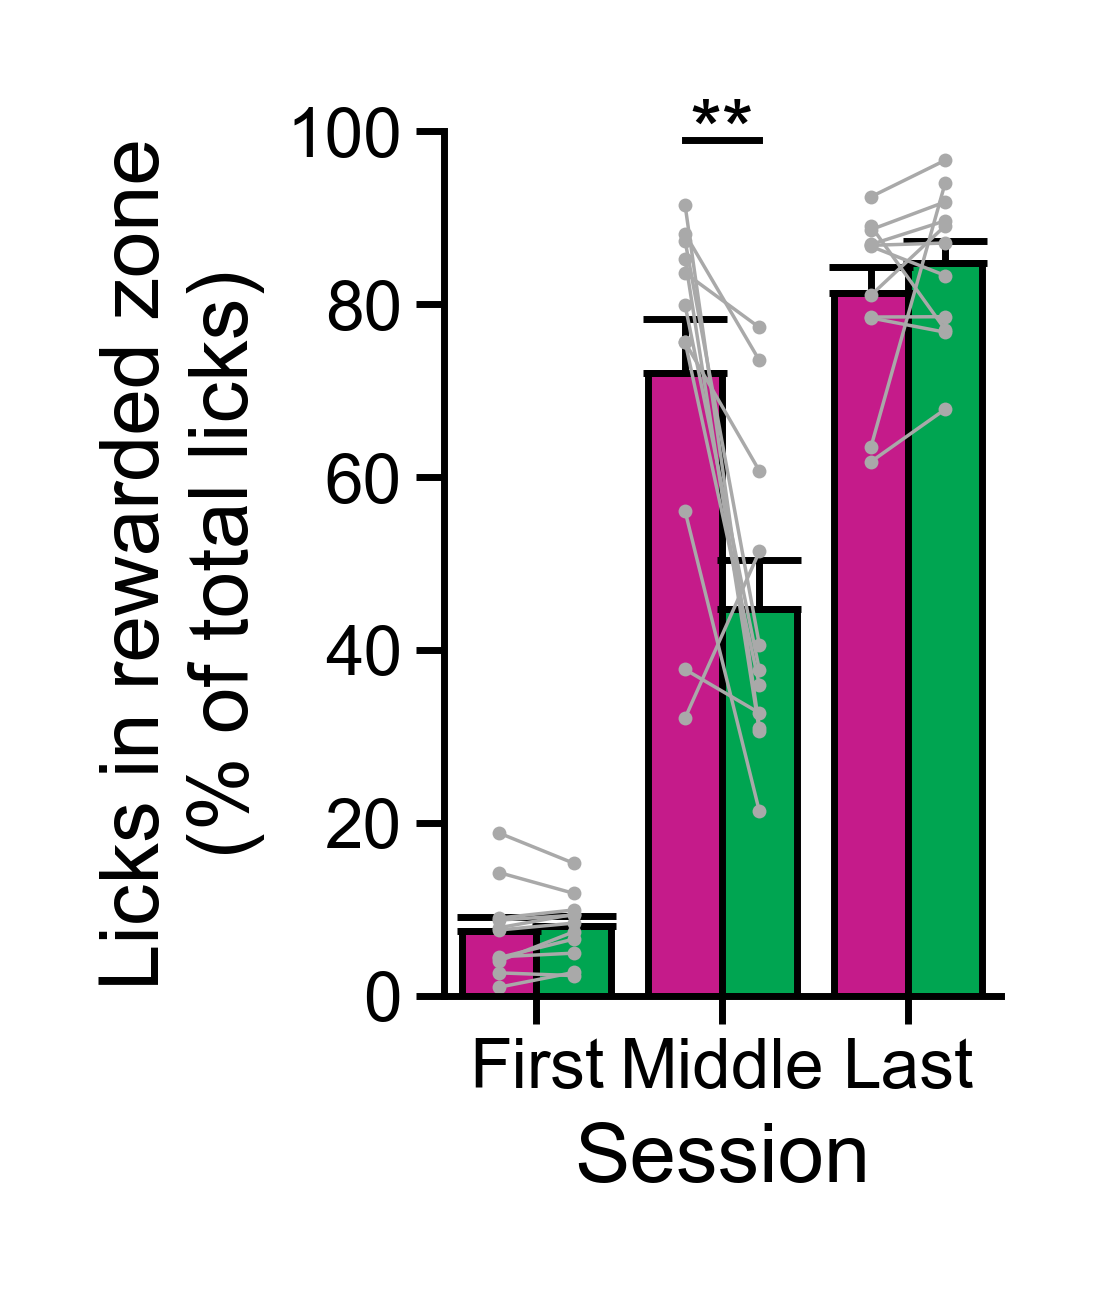

In [11]:
near_color = '#C51B8A'
far_color ='#00A551'
plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(25/25.4,30/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['bar'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1],
    # set the width ratios between the columns
    width_ratios=[1],
)

ax = axs['bar']
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Licks in rewarded zone\n(% of total licks)',fontsize=6)
ax.set_xlabel('Session')
ax.set_xlim(-0.5,2.5)
ax.set_xticks((0,1,2))
#ax.set_xticklabels(ax.get_xticks(), rotation = 90)
ax.set_xticklabels(('First','Middle','Last'))

x_position = np.arange(3)
bar_width=0.4
# bar plot near
ax.bar(x_position-bar_width/2, g_data.loc['near',('score','mean')], color =near_color, width = bar_width,
       edgecolor='black',linewidth=0.5)
ax.bar(x_position+bar_width/2, g_data.loc['far',('score','mean')], color =far_color, width = bar_width,
       edgecolor='black',linewidth=0.5)
# add error bars.
y_err = g_data.loc['near',('score','sem')]
y_err = [(0,0,0),(y_err[0],y_err[1],y_err[2])]
ax.errorbar(x_position-bar_width/2,  g_data.loc['near',('score','mean')], 
             yerr=y_err, fmt='none',solid_capstyle='projecting', capsize=3,color='black',capthick=0.5,elinewidth=0.5)
y_err = g_data.loc['far',('score','sem')]
y_err = [(0,0,0),(y_err[0],y_err[1],y_err[2])]
ax.errorbar(x_position+bar_width/2,  g_data.loc['far',('score','mean')], 
             yerr=y_err, fmt='none',solid_capstyle='projecting', capsize=3,color='black',capthick=0.5,elinewidth=0.5)
# Add individual animal plots
for animal in animals:
    for i_period, period in enumerate(['start','middle','end']):
        y_data = (data.loc[(animal,'near',period),'score'],data.loc[(animal,'far',period),'score'])
        ax.plot((i_period-bar_width/2, i_period+bar_width/2),y_data,color='darkgray',alpha=1,linestyle='-',linewidth=0.25,markersize=1,markerfacecolor='darkgray')
# add significant check.
if ttest.pvalue <0.05:
    if (ttest.pvalue <0.05) & (ttest.pvalue >0.01):
        sig_str = '*'
    elif (ttest.pvalue<0.01 )& (ttest.pvalue >0.001):
        sig_str = '**'
    else:
        sig_str = '***'
    ax.plot((1-bar_width/2, 1+bar_width/2),(99,99),marker='',color='black')
    ax.text(1,95,sig_str,ha='center',va='bottom',fontsize=6)
    
ax.set_ylim(0,100)

# create legend
#ax = axs['legend']
#ax.axis('off')
#ax.text(-0.1,1,'Near',color = near_color,va='top')
#ax.text(-0.1,0.90,'Far',color = far_color,va='top')

## Legend text

In [14]:

print(f'n: {len(info)} animals, p: {ttest.pvalue:.5f} dependent samples t-test')

n: 11 animals, p: 0.00432 dependent samples t-test
